In [56]:
import numpy as np
import numpy.ma as ma
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import ArtistAnimation, FFMpegWriter
import matplotlib.cm as cm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import COASTLINE, LAND

bad_value = -999 
num_cols = 1440
num_rows = 720

In [57]:
def get_longitudes(num):
    start = 0.125

    i=0
    longs = []
    while (i<num):
        longs.append(start)
        i+=1
        start+=0.25
    
    return longs

In [58]:
def read_dataset(name):

    max_length = 1440

    f = open(name)
    lines = f.readlines()
    lines = lines[7:]

    splitted_dict = {}

    for i in lines:
        i = i.strip()
        line = re.split(r'[\t\n]',i)
        if (line[-1].find("** line too long **")) or (line[-1] == "** line too long **"):
            line.pop() 
        
        temp = []
        for j in range(1, len(line)):
            temp.append(float(line[j]))
            
        splitted_dict[line[0]] = temp
    
    rain = []
    for i in splitted_dict.keys():

        length = len(splitted_dict[i])
        if (length < max_length):
            max_length = length
    
    for i in splitted_dict.keys():
        temp = []
        j = 0
        while (j<len(splitted_dict[i])):
            temp.append(splitted_dict[i][j])
            j+=1
        while (j<1440):
            temp.append(bad_value)
            j+=1
        rain.append(temp)

    rain = np.array(rain)
    return rain, max_length

In [59]:
def get_color_plot(rain, ax, cax, cmap, norm, extent):

    rain_masked = ma.masked_where(rain == bad_value, rain)
    # fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},figsize=(20,15))

    im = ax.imshow(rain_masked, cmap=cmap, extent=(-180, 180, -90, 90), origin='lower', transform=ccrs.PlateCarree(central_longitude=180), norm=norm, animated=True)

    posn = ax.get_position()
    cax.set_position([posn.x0 + posn.width + 0.01, posn.y0, 0.02, posn.height])
    
    cbar = plt.colorbar(im, cax=cax, orientation='vertical', shrink=0.6)    
    cbar.set_label('Rain')
    
    ax.add_feature(COASTLINE, linewidth=0.5, edgecolor='black')
    ax.add_feature(LAND,facecolor='lightyellow')

    ax.gridlines(draw_labels=True)
    ax.gridlines(xlocs=range(-180, 181, 30), ylocs=range(-90, 91, 30), linestyle='--', color='k')
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    ax.set_extent([0,extent,-90,90], ccrs.PlateCarree())

    return im

In [60]:
def make_video(datasets, colormap, extent):

    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))

    cax = fig.add_axes([0,0,0.1,0.1])

    scale = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.16, 0.22, 0.3, 30]
    norm = mcolors.BoundaryNorm(scale, len(scale)-1)
    cmap = cm.get_cmap(colormap)
    colors = []
    factor = 1/(len(scale)-1)

    for i in range(0, len(scale)):
        colors.append(cmap(i*factor))
    cmap=mcolors.ListedColormap(colors)

    ims = []

    for i in range(len(datasets)):
        im = get_color_plot(datasets[i], ax, cax, cmap, norm, extent)
        ims.append([im])

    animation = ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)

    plt.show()

    writer = FFMpegWriter(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    animation.save(colormap+"1.mp4", writer=writer)

In [61]:
def load_data(strings):

    datasets = []
    min_length = 1440

    for i in strings:
        data, length = read_dataset(i)
        if (length < min_length):
            min_length = length
        
        datasets.append(data)
    
    return datasets,min_length

/tmp/ipykernel_7184/65120637.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


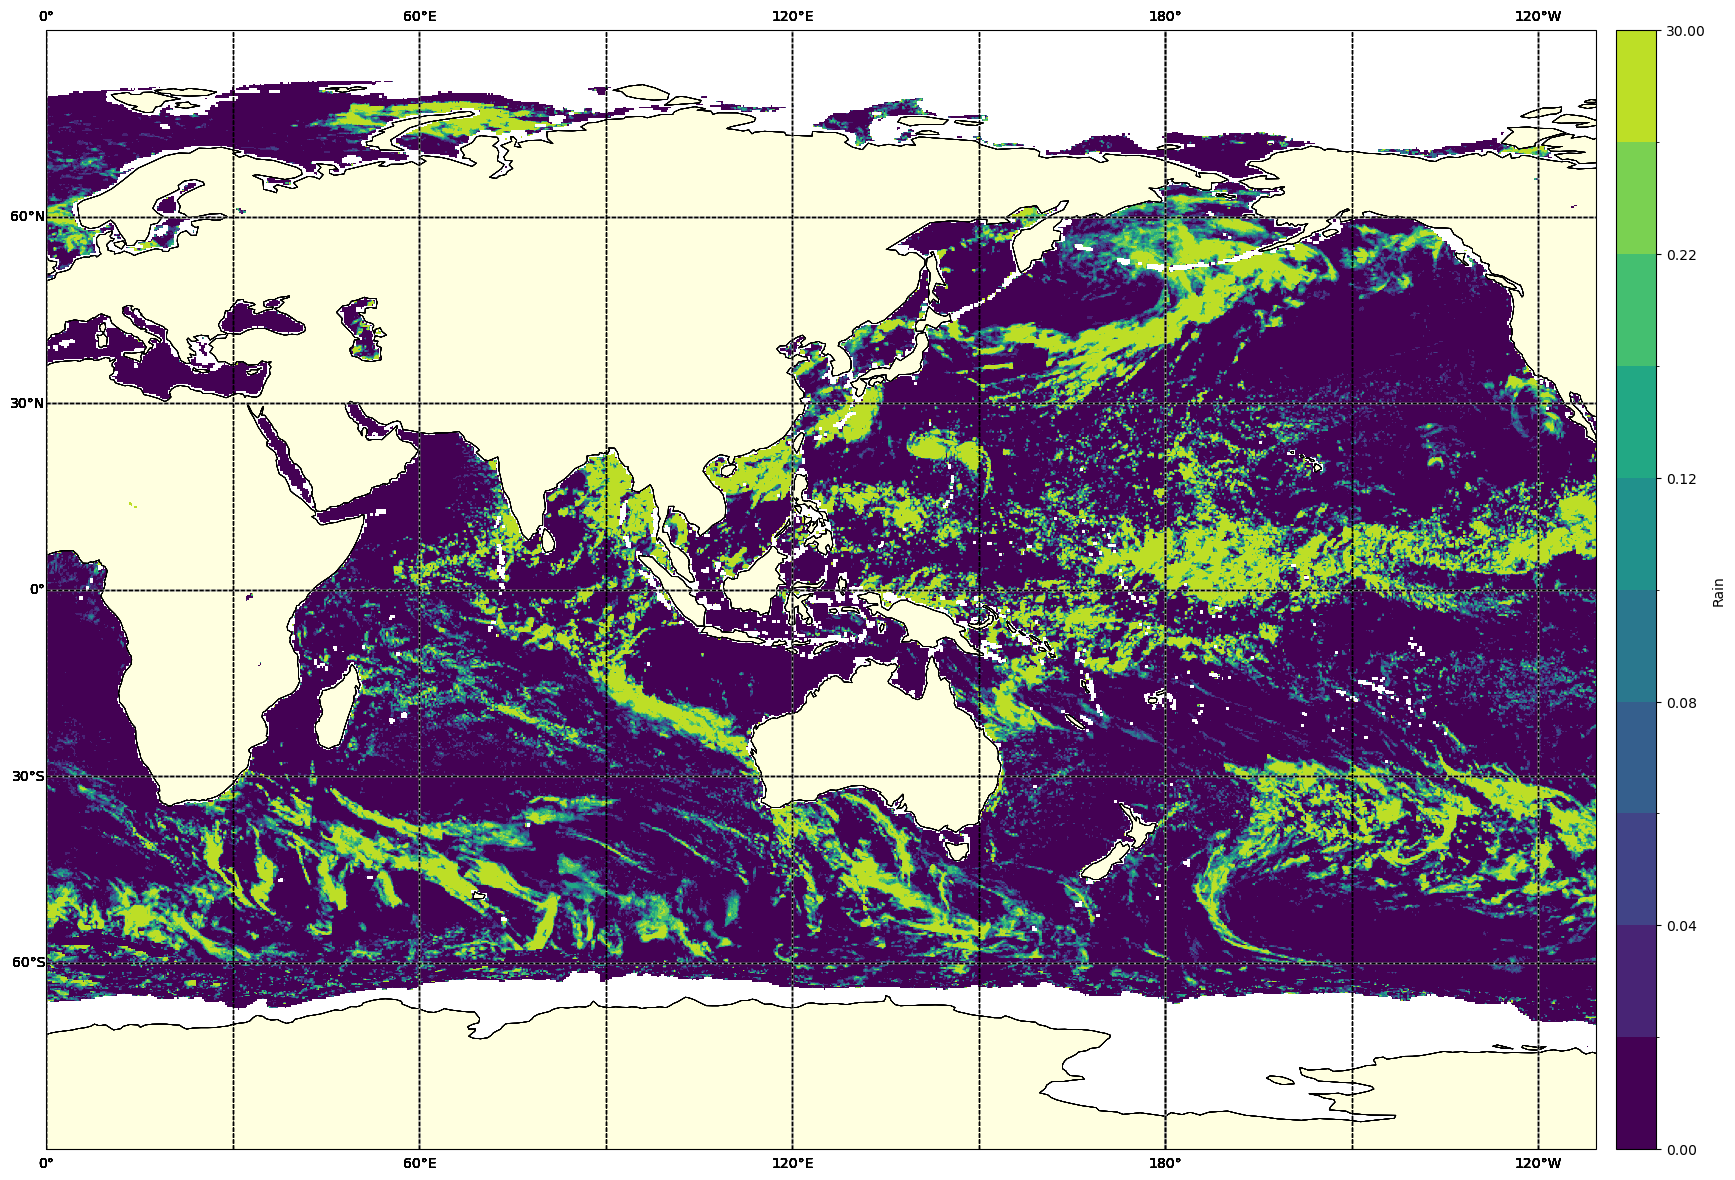

/tmp/ipykernel_7184/65120637.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


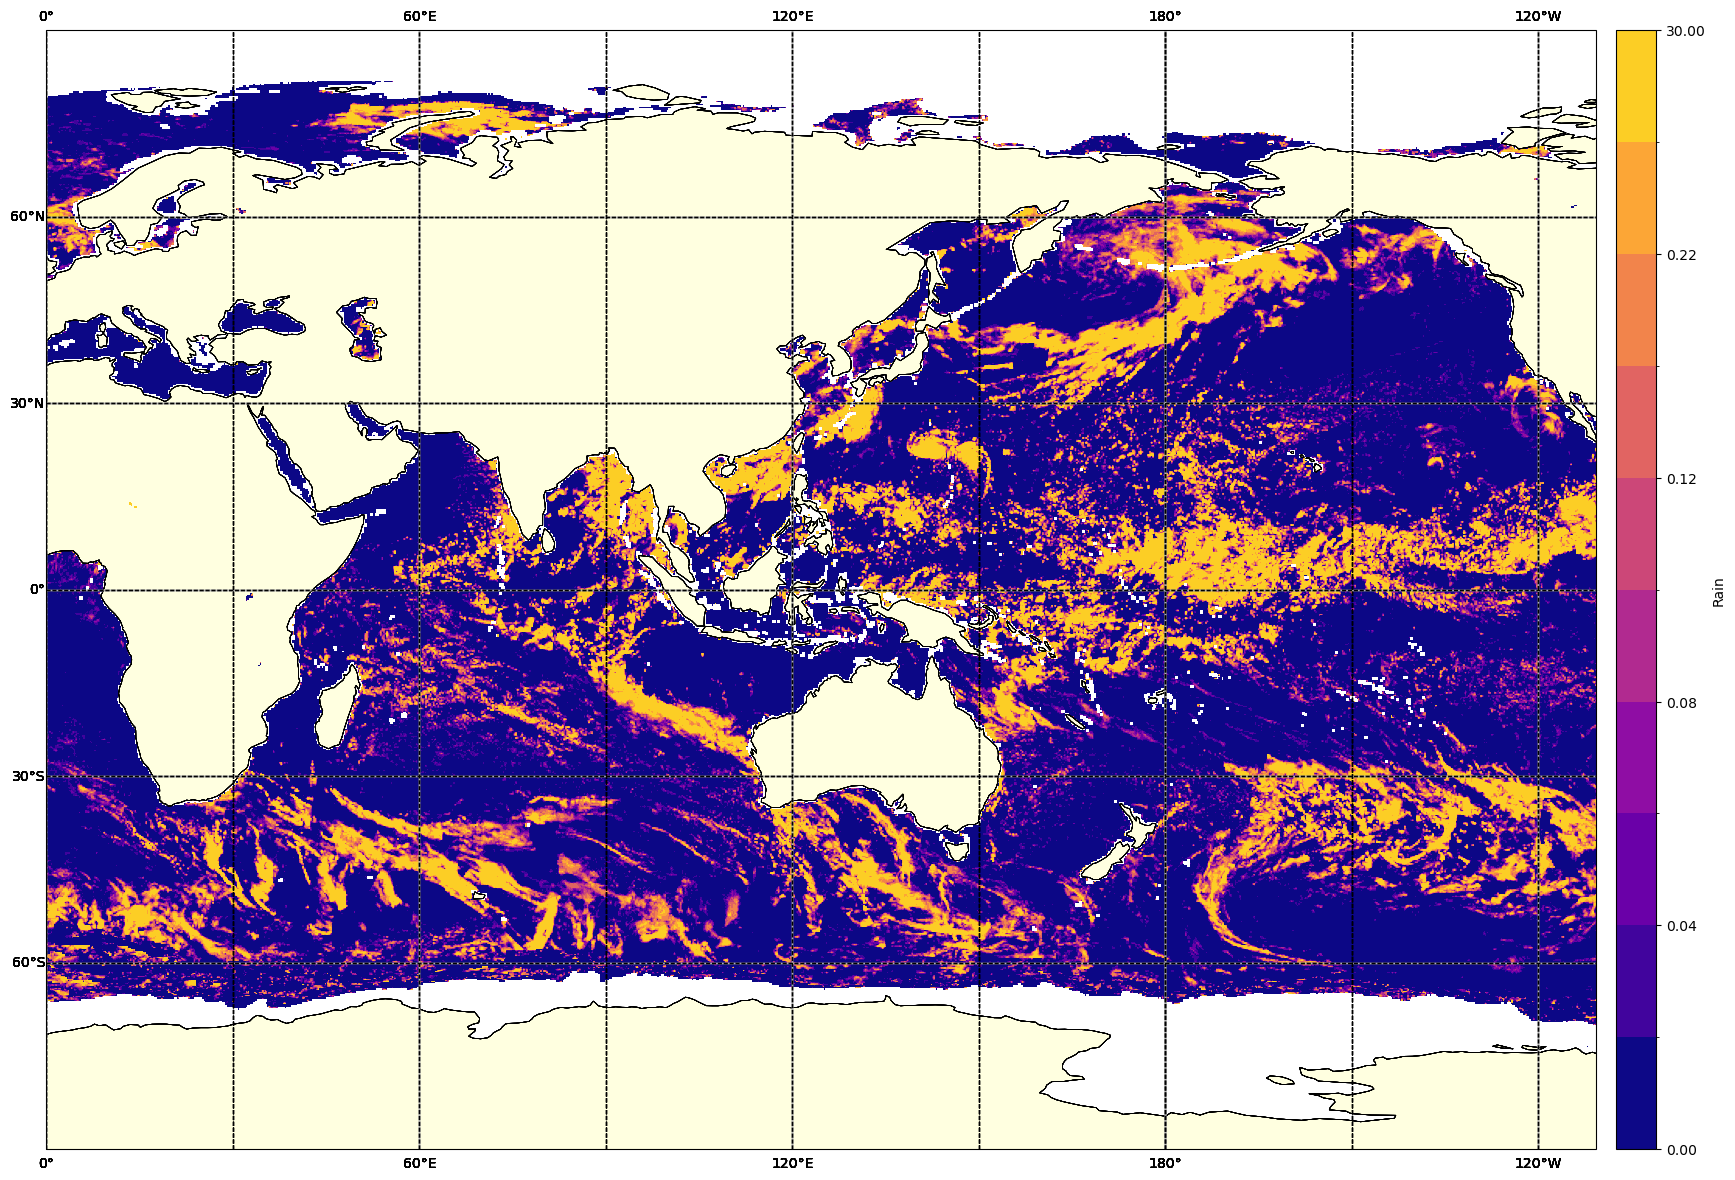

/tmp/ipykernel_7184/65120637.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


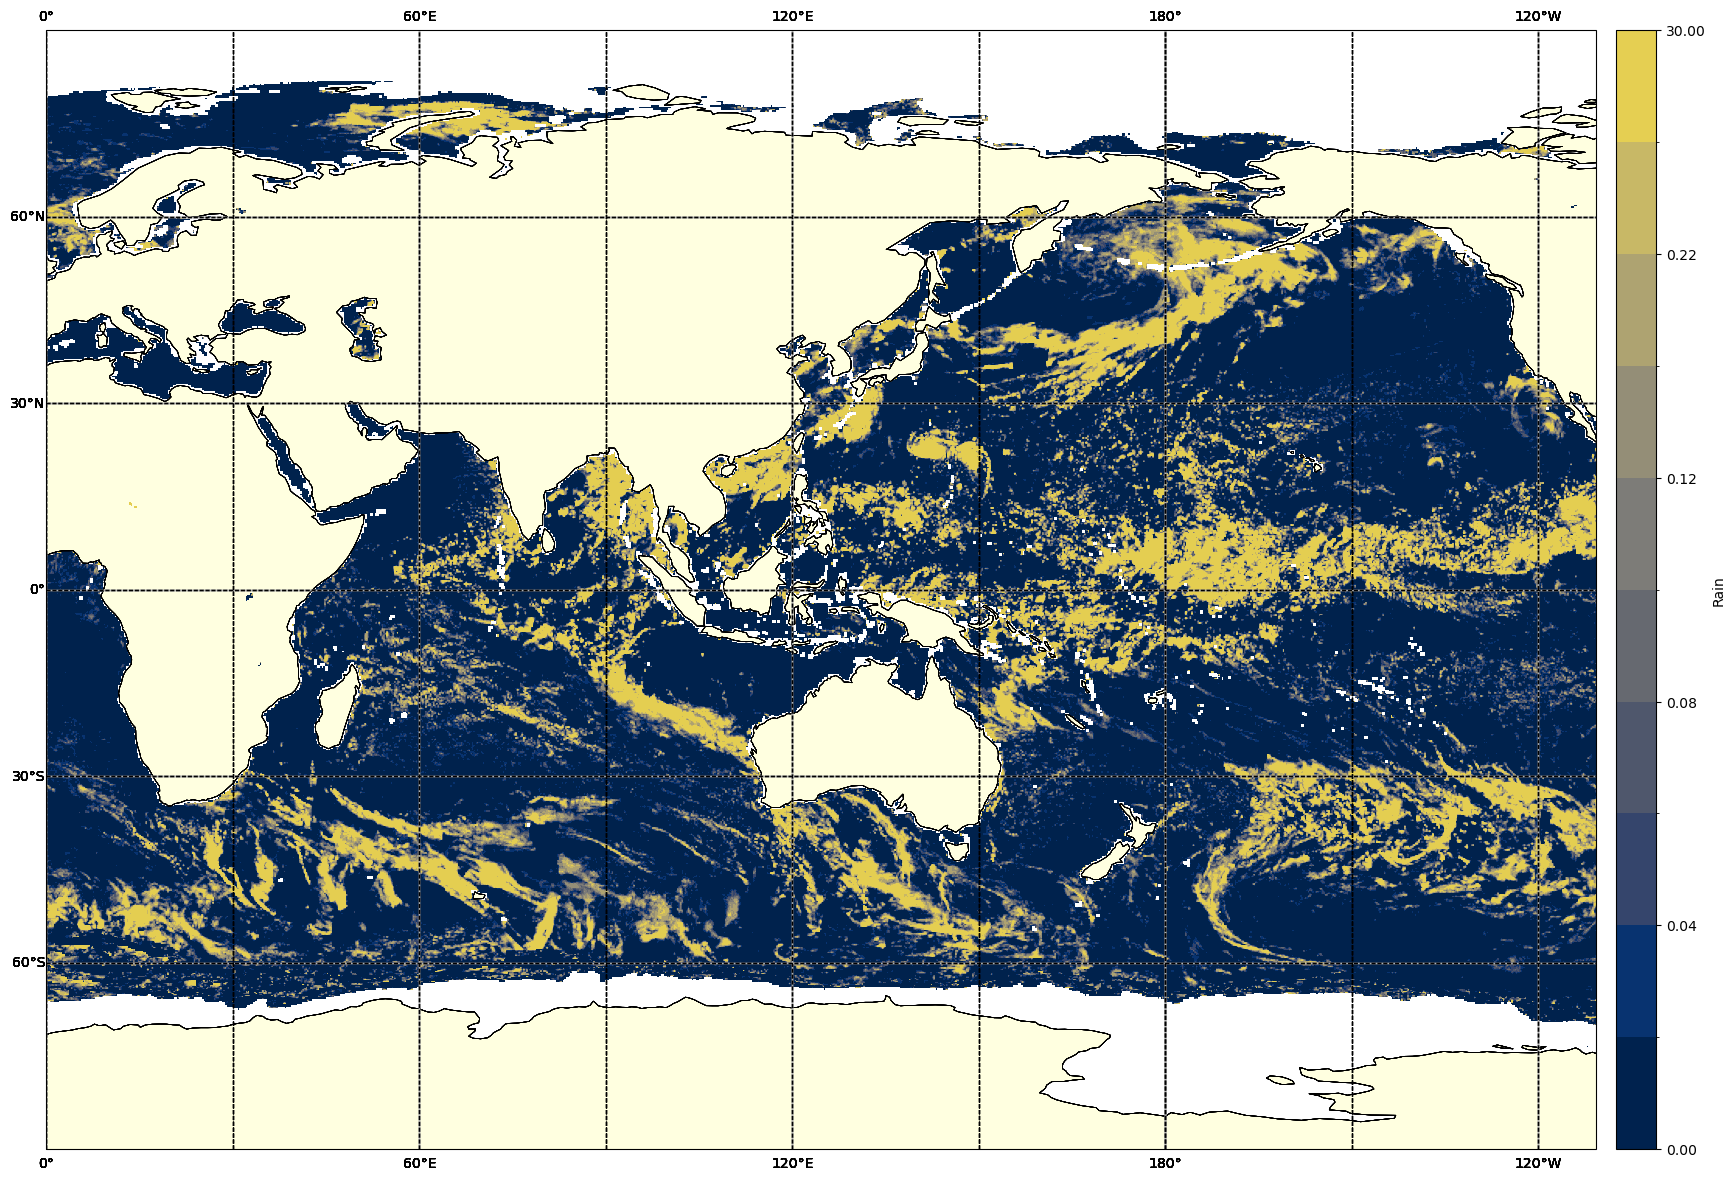

/tmp/ipykernel_7184/65120637.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


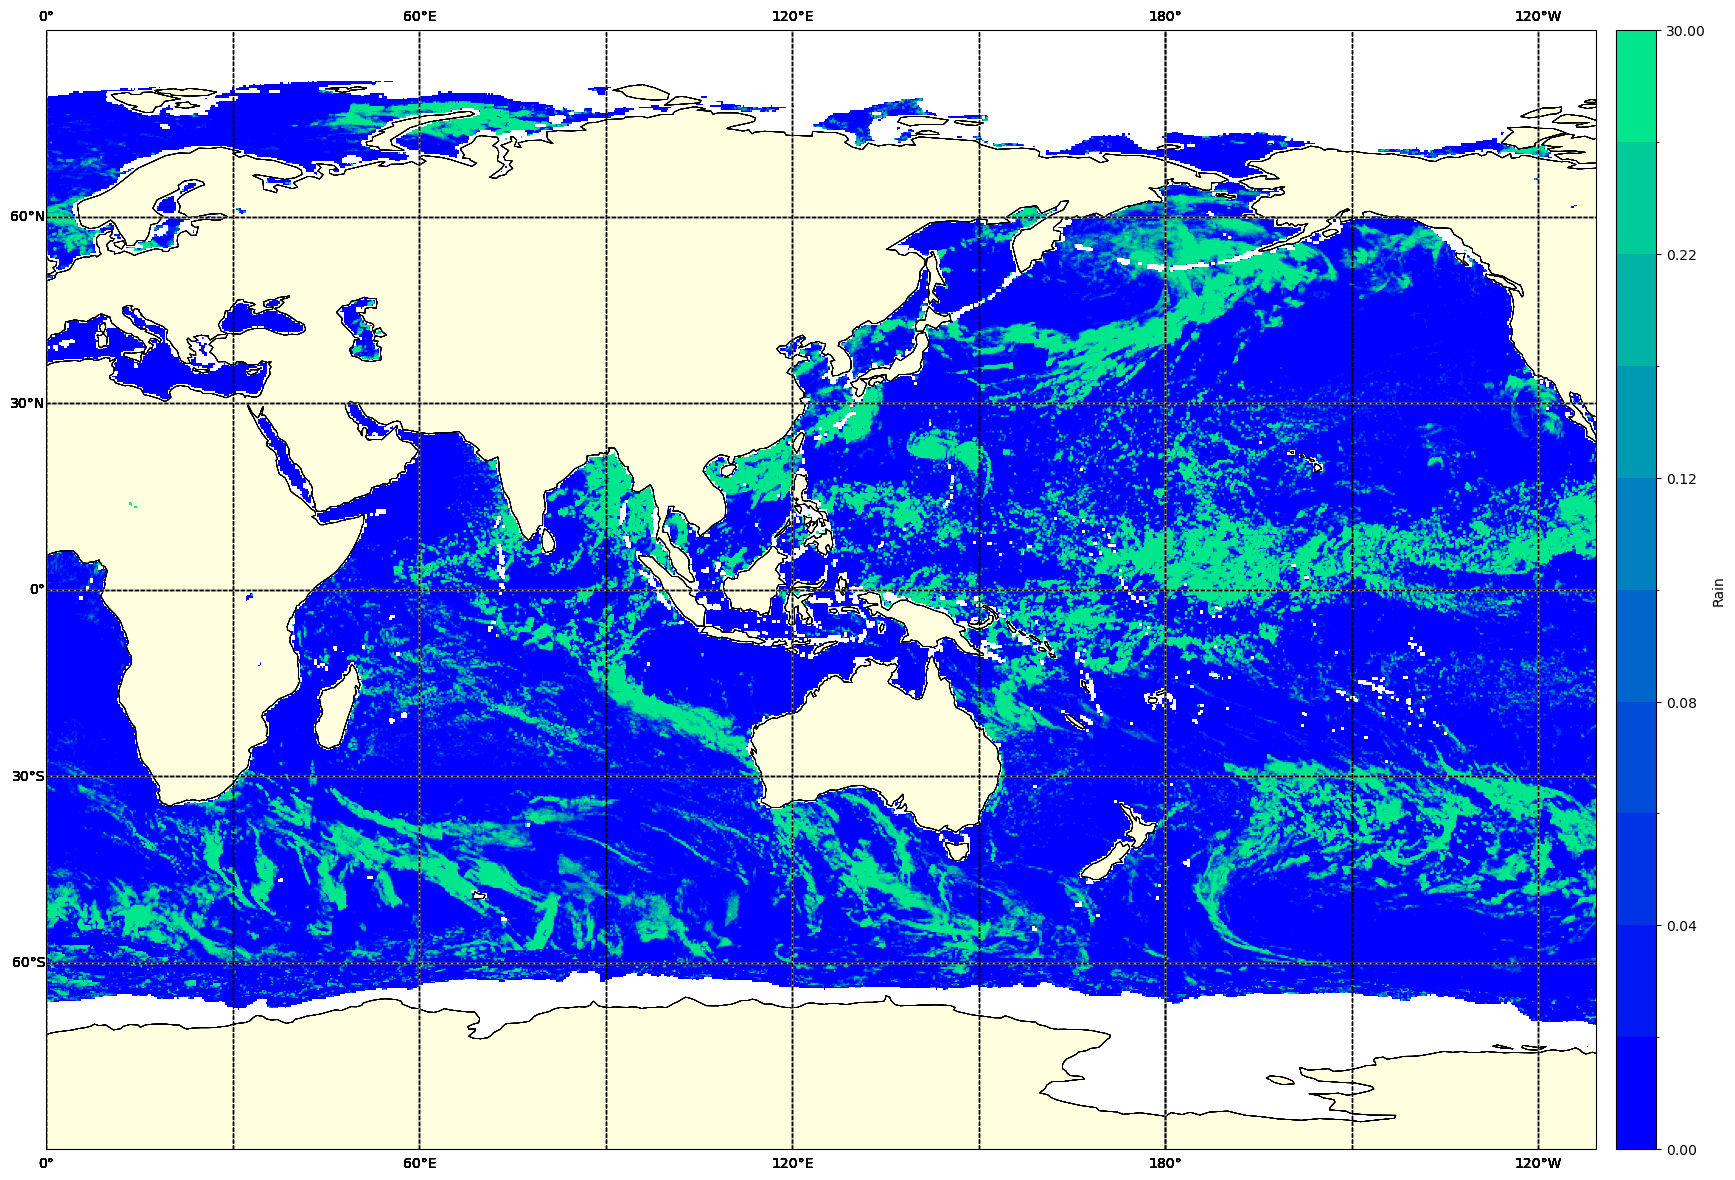

In [62]:
colormaps = ['viridis','plasma','cividis','winter']
strings = ["./dataset/1_May_2015.txt","./dataset/11_May_2015.txt","./dataset/21_May_2015.txt","./dataset/1_Jun_2015.txt","./dataset/11_Jun_2015.txt",
           "./dataset/21_Jun_2015.txt","./dataset/1_Jul_2015.txt","./dataset/11_Jul_2015.txt","./dataset/21_Jul_2015.txt"]

datasets,min_length = load_data(strings)
extent = get_longitudes(num_cols)[min_length]

for color in colormaps:
    make_video(datasets, color, extent)